In [1]:
## Bring in needed mods
import numpy as np, pandas as pd, scipy.stats as ss
import seaborn as sns, os
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
## Set random seed
np.random.seed(71191)

In [3]:
## Define functions
def allelic_ANOVA(site, pheno):
    """
    This regression is equivalent to one-way ANOVA with 2 groups. 
    Return F-statistic.
    Assumes site is coded as -1, 1
    """
    coding = np.array(site, np.float)
    pheno = np.array(pheno, np.float)
    
    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    ##R = len_yhat/len_y
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F

def association_logPval(site, pheno):
    F = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP

In [4]:
## Define labels
from matplotlib import rc
xl280al = 'XL280'+r'$\alpha$'#+'SS'
xl280_label = 'XL280' +r'$\bf{a}$'
_431_label = '431'+r'$\mathrm{\alpha}$'

In [5]:
## Bring in genotype data
genopath = '../DATA/GENOTYPE/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
gv = pd.read_csv(genopath)

In [6]:
## Bring in phenotype data (Melanin)
datapath = '../DATA/PHENOTYPE/MELANIN/L-DOPA-July32020.csv.gz'
mean_intensity = pd.read_csv(datapath,index_col=0)
mean_intensity.head()

,Row,Column,Plate,Replicate,Measurement,Mean_intensity,Strain
0,b,2.0,qtl1,0,0,11924.590,SS-B307
1,b,2.0,qtl1,0,1,11882.123,SS-B307
2,b,2.0,qtl1,0,2,11886.686,SS-B307
3,b,2.0,qtl1,1,0,12333.405,SS-B307
4,b,2.0,qtl1,1,1,12270.396,SS-B307


In [7]:
## Gather segregants
segs = np.array([s 
                 for s in mean_intensity.Strain.unique() 
                 if s in gv.columns])
segs.shape

(104,)

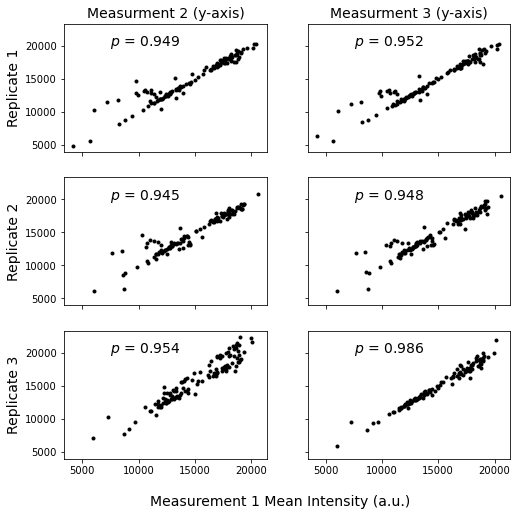

In [8]:
## Analysis of variation between measurements per replicate
fig,ax = plt.subplots(3,2,figsize=(8,8),sharex=True,sharey=True)

for i in mean_intensity.Replicate.unique():
    test = mean_intensity[(mean_intensity.Replicate==i)]

    x = test[(test.Measurement==0)].Mean_intensity.values
    y = test[(test.Measurement==1)].Mean_intensity.values
    plt.sca(ax[i,0])
    plt.plot(x,y,'k.');
    sp = np.round(ss.spearmanr(x,y)[0],3)
    plt.text(7500,20000,'$p$ = %s'%sp,fontsize=14)
    plt.title('Measurment 2 (y-axis)' if i == 0 else None,fontsize=14)
    plt.ylabel('Replicate %s'%str(i+1),fontsize=14)
    

    x = test[(test.Measurement==0)].Mean_intensity.values
    y = test[(test.Measurement==2)].Mean_intensity.values
    plt.sca(ax[i,1])
    plt.plot(x,y,'k.');
    sp = np.round(ss.spearmanr(x,y)[0],3)
    plt.text(7500,20000,'$p$ = %s'%sp,fontsize=14);
    plt.title('Measurment 3 (y-axis)' if i == 0 else None,fontsize=14)

fig.text(0.5,0.05,'Measurement 1 Mean Intensity (a.u.)',
         fontsize=14,va='center',ha='center');
plt.savefig('/home/croth/Desktop/QTL_REPLICATES/Melanin_measurements_rank_coeff.png',
            dpi=100,bbox_inches='tight');

In [9]:
## Take the median measurment per strain
melanin_replicates = mean_intensity.groupby(['Strain','Replicate']).aggregate('median').reset_index()
melanin_replicates.head()

,Strain,Replicate,Column,Measurement,Mean_intensity
0,SS-A837,0,7.0,1,11578.015
1,SS-A837,1,7.0,1,10390.454
2,SS-A837,2,7.0,1,11540.937
3,SS-B307,0,2.0,1,11886.686
4,SS-B307,1,2.0,1,12333.405


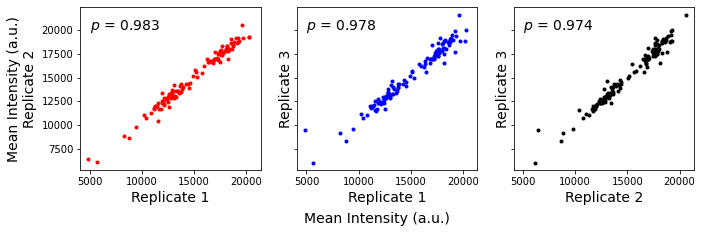

In [10]:
## Calculate the pair-wise replicate rank corrilation coefficents
fig,ax = plt.subplots(1,3,figsize=(11,3),sharex=True,sharey=True)
## Replicate 0 vs 1
plt.sca(ax[0])
x = melanin_replicates[(melanin_replicates.Replicate==0)].Mean_intensity.values
y = melanin_replicates[(melanin_replicates.Replicate==1)].Mean_intensity.values

plt.plot(x,y,'r.')
plt.xlabel('Replicate 1',fontsize=14);
plt.ylabel('Mean Intensity (a.u.)\nReplicate 2',fontsize=14)

sp = np.round(ss.spearmanr(x,y)[0],3)
plt.text(5000,20000,'$p$ = %s'%sp,fontsize=14)

## Replicate 0 vs 2
plt.sca(ax[1])
x = melanin_replicates[(melanin_replicates.Replicate==0)].Mean_intensity.values
y = melanin_replicates[(melanin_replicates.Replicate==2)].Mean_intensity.values

plt.plot(x,y,'b.')
plt.xlabel('Replicate 1',fontsize=14);
plt.ylabel('Replicate 3',fontsize=14)

sp = np.round(ss.spearmanr(x,y)[0],3)
plt.text(5000,20000,'$p$ = %s'%sp,fontsize=14)

## Replicate 1 vs 2
plt.sca(ax[2])
x = melanin_replicates[(melanin_replicates.Replicate==1)].Mean_intensity.values
y = melanin_replicates[(melanin_replicates.Replicate==2)].Mean_intensity.values

plt.plot(x,y,'k.')
plt.xlabel('Replicate 2',fontsize=14);
plt.ylabel('Replicate 3',fontsize=14)

sp = np.round(ss.spearmanr(x,y)[0],3)
plt.text(5000,20000,'$p$ = %s'%sp,fontsize=14)


fig.text(0.5,-0.1,'Mean Intensity (a.u.)',fontsize=14,va='center',ha='center');
plt.savefig('/home/croth/Desktop/QTL_REPLICATES/Melanin_replicates_rank_coeff.png',
            dpi=100,bbox_inches='tight');

In [11]:
## Take the average mean intensity across replicates 
## of the median measurment per strain
melanin = melanin_replicates.groupby('Strain').aggregate('mean')
melanin = melanin.loc[segs,:]
melanin.head()

,Replicate,Column,Measurement,Mean_intensity
Strain,,,,
SS-B307,1,2.0,1,12310.311000
SS-B310,1,4.0,1,12255.142667
SS-B311,1,5.0,1,14045.272333
SS-B312,1,6.0,1,18635.336333
SS-B313,1,7.0,1,16597.829333


In [12]:
## Conduct QTL mapping on mean intensity phenotype
pheno = 'Mean_intensity'

## Gather unique loci (haplo groups)
test = gv[segs].drop_duplicates()

## Associate QTL
test[pheno] = test.apply(association_logPval,
                         args=[melanin[pheno][segs]],
                         axis=1)

## Merge data
pval_df = gv.merge(test)

In [13]:
## Conduct permutation tests
nperms = 10000
perm_path = '../DATA/PERMUTATIONS/Melanin_MI_QTL_perms_%s_null.csv.gz'%(
    nperms)

if os.path.exists(perm_path):
    perms = np.concatenate(
        pd.read_csv(perm_path,header=None).values)
else:
    perms = []
    for i in range(nperms):
        phenotype = pd.Series(np.random.permutation(melanin[pheno][segs]),
                          index=segs)
        
        maxpval = np.max(gv.loc[loci][segs].apply(
                    association_logPval,args=[phenotype[segs]],axis=1))
        
        perms.append(maxpval)
        
    open(perm_path,'w'
        ).writelines('\n'.join(np.array(perms,dtype='str')))
    perms = np.array(perms)
perms.shape

(10000,)

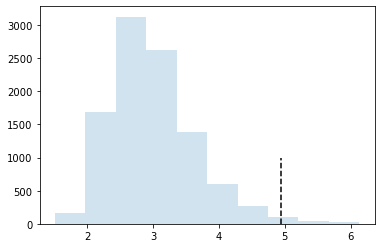

In [14]:
## Plot null distribution
plt.hist(perms,alpha=0.2);
plt.vlines(np.percentile(perms,99),
           0,len(perms)/10,linestyle='--',color='k');
##plt.vlines(pval_df[pheno].max(),0,500,color='r');

In [15]:
## Gather chromosome information and lenghts
chrlist = sorted(pval_df.Chrom.unique())
chrlens = np.array([pval_df[(pval_df.Chrom==c)].Pos.max() 
           for c in chrlist])
cumpos = np.array([0] + list(np.cumsum(chrlens[:-1])))
cummax = cumpos[-1] + pval_df[(pval_df.Chrom=='Chr14')].Pos.max()
chrmid = (chrlens/2) + cumpos

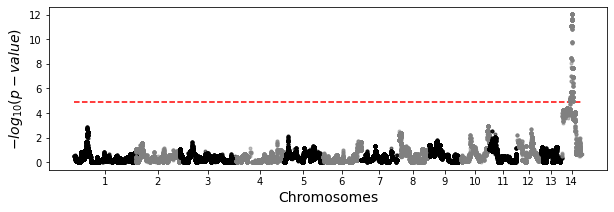

In [16]:
## Plot initial QTL map
fig,ax = plt.subplots(1,1,figsize=(10,3));
for c in chrlist:
    i = int(c[3:])-1
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos+cumpos[i],temp[pheno],'.',
             color='k' if i%2==0 else 'grey',
             alpha = 0.5)
plt.xticks(chrmid,np.arange(len(chrlist))+1);
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosomes',fontsize=14);
plt.hlines(4.93,0,temp.Pos.max()+np.max(cumpos),
           linestyles='--',color='r');

In [17]:
## Save out QTL data for later use
pval_df.to_csv('../DATA/PHENOTYPE/MELANIN/Melanin_QTL_pvalues.csv.gz',index=True)
pval_df.tail()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382,Mean_intensity
92098,Chr14,726789,117457.0,1.0,C,T,1,7112,snp,24495,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.677653
92099,Chr14,727291,148245.0,1.0,G,A,1,8089,snp,24520,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.677653
92100,Chr14,731761,144813.0,1.0,C,T,1,7635,snp,24696,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.677653
92101,Chr14,735057,139770.0,1.0,A,G,1,7777,snp,24762,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.677653
92102,Chr14,745415,155353.0,1.0,T,C,1,8520,snp,24961,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.677653


In [18]:
## Gather dataframe index of QTL peak
qtlix = pval_df[(pval_df.Chrom=='Chr14')][pheno].idxmax()
qtlix

90495

In [19]:
## Bring in more needed mods
from matplotlib.gridspec import GridSpec
import statsmodels.formula.api as smf

In [20]:
## And even more
from PIL import Image
plt.style.use(['tableau-colorblind10'])

In [21]:
## Gather chromosome 14 resutls
ch14 = pval_df[(pval_df.Chrom=='Chr14')]

In [22]:
## Drop missing values if any
if melanin.shape[0] != melanin.dropna().shape[0]:
    melanin.dropna(inplace=true)

In [23]:
## Gather peak QTL genotype
melanin['QTL14'] = ch14.T[ch14[pheno].idxmax()].T[melanin.index].apply(int)

In [24]:
## Set variables for plotting
kb = 1000
chrom_colors = ['tab:grey','tab:brown','lightgrey','salmon','tan']

In [25]:
## Save out genotype by phenotype datarame for later use
melanin[melanin.columns[-2:]
       ].to_csv('../DATA/PHENOTYPE/MELANIN/Melanin_Phenotypes.csv')

In [26]:
## Conduct a linear regression to calcualte R2
results = smf.ols('Mean_intensity~QTL14',data=melanin).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Mean_intensity   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     66.59
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           9.17e-13
Time:                        22:58:03   Log-Likelihood:                -957.41
No. Observations:                 104   AIC:                             1919.
Df Residuals:                     102   BIC:                             1924.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.705e+04    347.488     49.076      0.000    1.64e+04    1.77e+04
QTL14      -3899.2723    477.832     -8.160      0.000   -4847.051   -2951.494
==============================================================================
Omnibus:                       27.801   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.415
Skew:                          -0.914   Prob(JB):                     4.20e-17
Kurtosis:                       6.750   Cond. No.                         2.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
## Name the heritability
mel_r_sq = np.round(results.rsquared,2)
mel_r_sq

0.39

/home/croth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "compression" which is no longer supported as of 3.3 and will become an error two minor releases later


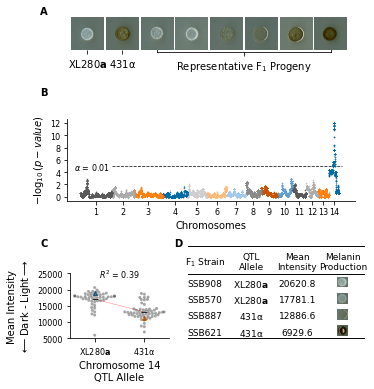

In [68]:
## Generate Figure 1 of Roth et al 2020
width = 6.9
height = 1.5
fig = plt.figure(figsize=(width,height))
gs = GridSpec(1, 4, figure=fig)
ax0 = fig.add_subplot(gs[0, :-1])

fs = 10
plt.sca(ax0)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
for c in chrlist[::-1]:
    i = int(c[3:])-1
    #if c == 'Chr14':
    #    cc = 'tab:blue'
    #else:
    cc = chrom_colors[i%len(chrom_colors)]
   
    temp = pval_df[(pval_df.Chrom==c)]
    plt.plot(temp.Pos+cumpos[i],temp[pheno].values,'.',
             alpha = 0.25,markersize=1,rasterized=True)
    
plt.xticks(chrmid,np.arange(len(chrlist))+1,fontsize=fs-2);
plt.ylabel('$-\log_{10}\,(p-value)$',fontsize=fs);

plt.xlabel('Chromosomes',fontsize=fs);
plt.yticks(np.arange(0,16,2),fontsize=fs-2)
plt.hlines(4.93,chrlens[0],19.1*(10**6),
           linestyles='dashed',color='k',
           alpha=0.9,linewidth=.8,rasterized=True);

plt.text(s = r'$\alpha$ = 0.01', x = 0.085,y= .42, 
         horizontalalignment='center',
         verticalalignment='center', 
         transform=ax0.transAxes, fontsize=fs-2)

plt.subplots_adjust(wspace=0.05)

plt.sca(ax0)
axs = fig.add_axes([0.305,1.50,.35,.1])
plt.xticks([0.5],labels=['Representative F$_1$ Progeny'],fontsize=fs)
plt.yticks([ ],labels=None)
axs.spines['top'].set_visible(False) 


## Plot xl280a
plt.sca(ax0)
axm = fig.add_axes([0.09,1.52,0.15,.3])
xl280a_path = '../IMAGES/ldopa_crop_segs/XL280a_LDOPA_day3_middle.png'
xl280a_obj = Image.open(xl280a_path)
plt.imshow(xl280a_obj,rasterized=True),# aspect='auto')
plt.xticks([40],labels=['XL280'+ r'$\bf{a}$'],fontsize=fs)
plt.yticks([]);
[axm.spines[a].set_visible(False) 
 for a in ['top','bottom','left','right']]

## Plot 431
plt.sca(ax0)
axm = fig.add_axes([0.16,1.52,0.15,.3])
plt.yticks([]);
A837_path = '../IMAGES/ldopa_crop_segs/SSA837_LDOPA_day3_middle.png'
A837_obj = Image.open(A837_path)
plt.imshow(A837_obj,rasterized=True),# aspect='auto')
plt.xticks([40],labels=['431'+'$\mathrm{\u03B1}$'],fontsize=fs)
[axm.spines[a].set_visible(False) 
 for a in ['top','bottom','left','right']]


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.23,1.52,0.15,.3])
plt.yticks([]);
spath = '../IMAGES/ldopa_crop_segs/S2_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj,rasterized=True),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.30,1.52,0.15,.3])
plt.yticks([]);
spath = '../IMAGES/ldopa_crop_segs/S6_LDOPA_day3_middle.png' #'./S1_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj,rasterized=True),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S1
axm = fig.add_axes([0.37,1.52,0.15,.3])
plt.yticks([]);
spath = '../IMAGES/ldopa_crop_segs/S1_LDOPA_day3_middle.png'#'./S3_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj,rasterized=True),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.44,1.52,0.15,.3])
plt.yticks([]);
spath = '../IMAGES/ldopa_crop_segs/S3_LDOPA_day3_middle.png'#'./S4_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj,rasterized=True),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.51,1.52,0.15,.3])
plt.yticks([]);
spath = '../IMAGES/ldopa_crop_segs/S5_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj,rasterized=True),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')


plt.sca(ax0)
## Plot S4
axm = fig.add_axes([0.58,1.52,0.15,.3])
plt.yticks([]);
spath = '../IMAGES/ldopa_crop_segs/S4_LDOPA_day3_middle.png'
sobj = Image.open(spath)
plt.imshow(sobj,rasterized=True),# aspect='auto')
plt.xticks([],labels=[])
plt.axis('off')

#### ------------------------------------------------------------ #####

plt.sca(ax0)
axl =  fig.add_axes([0.13,-1.15, 0.2,.6])
plt.sca(axl)

axl.spines['right'].set_visible(False)
axl.spines['top'].set_visible(False)

sns.regplot(x='QTL14',y=pheno,data=melanin,ci=False,
            scatter_kws={'alpha':0},
            line_kws={'linewidth':0.5,'alpha':0.5,'color':'r'}
           )

sns.swarmplot(x='QTL14',y=pheno,color='k',
              data=melanin,alpha=0.35,ax=axl,
              size=3,
              rasterized=True)


plt.plot(melanin.groupby('QTL14')[pheno].mean().index,
         melanin.groupby('QTL14')[pheno].mean().values,'k_',
        alpha=0.75,markersize=6)

plt.plot(1,melanin.loc['SS-A837'][pheno],'^',
         color='tab:orange',alpha=0.9,
         markersize=4)

plt.plot(0,melanin.loc['XL280a'][pheno],'^',
         color='tab:blue',alpha=0.85,
         markersize=4)


ymax = 25000
ymin = 5000
plt.ylim(ymin,ymax)
plt.yticks([5000,10000,15000,20000,25000],fontsize=fs-2)
xl280_name = 'XL280'+r'$\bf{a}$'
_431_name = '431'+u'$\mathrm{\u03B1}$'
plt.text(0.5,25000,'$R^2$ = %s'%mel_r_sq,fontsize=fs-2,ha='center',va='center')
plt.xticks([0,1],[xl280_name,_431_name],fontsize=fs-2)
plt.xlabel('Chromosome 14\nQTL Allele',fontsize=fs)


xl280strains = melanin[(melanin.QTL14==0)
                      ].sort_values(pheno).index.tolist()
_431strains = melanin[(melanin.QTL14==1)
                     ].sort_values(pheno).index.tolist()

lightest = xl280strains[-1]
darkest = _431strains[0]
xlmid = xl280strains[:(int(len(xl280a_path)/2))][-1]
_431mid = _431strains[:(int(len(_431strains)/2))][-1]
plt.ylabel('Mean Intensity\n$\longleftarrow$Dark - Light$\longrightarrow$',
           fontsize=fs);

plt.sca(axl)


axr =  fig.add_axes([0.37,-1.1, 0.32,.6])
to_plot = melanin.T[[lightest,darkest,xlmid,_431mid]
                   ].T.sort_values(pheno)[::-1]

[plt.text(0.1+(0.29*i),1.1,s=k, transform=axr.transAxes,
          fontsize=fs-1,va='center',ha='center') 
 for i,k in enumerate(['F$_1$ Strain','QTL\nAllele',
                       'Mean\nIntensity','Melanin\nProduction'])]

[plt.text(0.1,0.01+(0.25*i),s=''.join(k.split('-')), 
          transform=axr.transAxes,fontsize=fs-1,va='center',ha='center') 
 for i,k in enumerate(to_plot.index.tolist()[::-1])]

[plt.text(0.1+(.29),0.01+(0.25*i),s= xl280_name if k == 0 else _431_name, 
          transform=axr.transAxes,fontsize=fs-1,va='center',ha='center') 
 for i,k in enumerate(to_plot.QTL14.tolist()[::-1])]

[plt.text(0.1+(.29)+(.29),0.01+(0.25*i),s= np.round(k,1), 
          transform=axr.transAxes,fontsize=fs-1,va='center',ha='center') 
 for i,k in enumerate(to_plot[pheno].tolist()[::-1])]

plt.axis('off')
plt.sca(axl)

axm = fig.add_axes([0.628,-1.13 +.45,0.1,0.1])
plt.yticks([]);
k = 'SSB908'
spath = '../IMAGES/ldopa_crop_segs/%s_LDOPA_day3_middle.png'%k
sobj = Image.open(spath)
plt.imshow(sobj,rasterized=True)
plt.xticks([],labels=[])
plt.axis('off')

axm = fig.add_axes([0.628,-1.13 +.30,0.1,0.1])
plt.yticks([]);
k = 'SSC242'
spath = '../IMAGES/ldopa_crop_segs/%s_LDOPA_day3_middle.png'%k
sobj = Image.open(spath)
plt.imshow(sobj,rasterized=True)
plt.xticks([],labels=[])
plt.axis('off')

axm = fig.add_axes([0.628,-1.13 +.15,0.1,0.1])
plt.yticks([]);
k = 'SSB887'
spath = '../IMAGES/ldopa_crop_segs/%s_LDOPA_day3_middle.png'%k
sobj = Image.open(spath)
plt.imshow(sobj,rasterized=True)
plt.xticks([],labels=[])
plt.axis('off')

axm = fig.add_axes([0.628,-1.13,0.1,0.1])
plt.yticks([]);
k = 'SSB621'
spath = '../IMAGES/ldopa_crop_segs/%s_LDOPA_day3_middle.png'%k
sobj = Image.open(spath)
plt.imshow(sobj,rasterized=True)
plt.xticks([],labels=[])
plt.axis('off')

fig.text(0.07,1.85,'A',fontsize=fs,fontweight='bold')
fig.text(0.07,1.1,'B',fontsize=fs,fontweight='bold')
fig.text(0.07,-0.3,'C',fontsize=fs,fontweight='bold')
fig.text(0.34,-0.3,'D',fontsize=fs,fontweight='bold')

plt.sca(axr)

fig.add_axes([0.367,-1.15,0.356,.0006]);plt.xticks([],[]);plt.yticks([],[])
fig.add_axes([0.367,-.3, 0.356,.00000001]);plt.xticks([],[]);plt.yticks([],[])
fig.add_axes([0.367,-.56, 0.356,.0006]);plt.xticks([],[]);plt.yticks([],[])

mydpi = 600
qtlpaper_save = '../FIGURES/MAIN/TIFF/Fig1.tiff'
pdf_save = '../FIGURES/MAIN/PDFs/Fig1.pdf'

plt.savefig(qtlpaper_save,
           dpi=mydpi,bbox_inches='tight',
            compression='tiff_lzw');

plt.savefig(pdf_save,
           dpi = mydpi,bbox_inches='tight',
            pad_inches=1);

im = Image.open(qtlpaper_save)
w,h = im.size

assert w/mydpi > 2.63
assert w/mydpi < 7.5
assert h/mydpi < 8.5
    
im.save(qtlpaper_save,compression='tiff_lzw');

In [29]:
assert 1 ==0

AssertionError: 

In [ ]:
## Fix the QTL genotype on chromosome 14
seg_x = melanin[(melanin.QTL14==0)].index.tolist()
seg_4 = melanin[(melanin.QTL14==1)].index.tolist()

## How many segregants do we have in each group
## should be around 50:50
len(seg_x),len(seg_4)

In [ ]:
## Conduct QTL mapping on mean intensity phenotype
pheno = 'Mean_intensity'

## Gather unique loci (haplo groups)
test_x = gv[seg_x].drop_duplicates()

## Associate QTL
test_x[pheno] = test_x.apply(association_logPval,
                         args=[melanin[pheno][seg_x]],
                         axis=1)

## Merge data
pval_df['QTL_x'] = gv.merge(test_x)['Mean_intensity']

In [ ]:
## Conduct QTL mapping on mean intensity phenotype
pheno = 'Mean_intensity'

## Gather unique loci (haplo groups)
test_4 = gv[seg_4].drop_duplicates()

## Associate QTL
test_4[pheno] = test_4.apply(association_logPval,
                         args=[melanin[pheno][seg_4]],
                         axis=1)

## Merge data
pval_df['QTL_4'] = gv.merge(test_4)['Mean_intensity']

In [ ]:
## These thresholds were already calculated
## set to zero to re run permutation below
thres_4 = 3.972
thres_x = 4.273

In [ ]:
## Conduct permutaitons for test of additional QTL
perm_x = []
perm_4 = []

pheno = 'Mean_intensity'
perms_temp = 1000

if thres_4 + thres_x == 0:
    for i in range(perms_temp):
    
        ## Permute phenotypes, for segregants with 431 QTL allele
        temp4 = pd.Series(np.random.permutation(
            melanin[pheno][seg_4]),index=seg_4)
    
        ## For the progeny with XL280 QTL allele
        tempx = pd.Series(np.random.permutation(
            melanin[pheno][seg_x]),index=seg_x)
    
        ## Gather genotype information
        test_4 = gv[temp4.index].drop_duplicates()
        test_x = gv[tempx.index].drop_duplicates()

        ## Take max association for both sets of progeny
        test_4_max = test_4.apply(association_logPval,
                         args=[temp4.values],
                         axis=1).max()
        test_x_max = test_x.apply(association_logPval,
                         args=[tempx.values],
                         axis=1).max()
    
        ## Append genome-wide max value
        perm_4.append(test_4_max)
        perm_x.append(test_x_max)
    
    ## Calculate thresholds
    thres_4 = np.percentile(perm_4,95)
    thres_x = np.percentile(perm_x,95)
    
thresholds = [thres_x,thres_4]
thresholds

In [ ]:
## Plot split QTL
fig, ax = plt.subplots(2,1,figsize=(12,4),sharey=True,sharex=True)

title = 'Progeny with %s\nChromosome 14 QTL allele'

for ri, q in enumerate(['QTL_x','QTL_4']):
    
    plt.sca(ax[ri])
    plt.hlines(thresholds[ri],0,np.max(cumpos[:-2])+np.max(chrlens),
               linestyle='-.',color='k')
    
    plt.title(title%xl280_label if ri ==0 else title%_431_label,
              x = .15,y=.5,fontsize=10)
    for c in chrlist:
        ci = int(c[3:])-1
        
        tempdf = pval_df[(pval_df.Chrom==c)].sort_values('Pos')
        
        plt.plot(tempdf.Pos.values+cumpos[ci],tempdf[q],'-.',ms=2)
        
plt.xticks(chrmid,np.arange(1,15));
plt.xlabel('Chromosome',fontsize=14)
fig.text(x=0.091,y=0.5,s='$-\log_{10}\,(p-value)$',
         rotation=90,fontsize=14,va='center',ha='center');
plt.savefig('/home/croth/Melanin_QTL_split_analysis.png',dpi=100,bbox_inches='tight');